#Libraries
------
-------------

In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install nltk


from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import Trainer, TrainingArguments

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# the following code ensures that you can see your (print) results for multiple tasks within a coding block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# read the data and preprocessing
--------
----------
==> at this part i used wordnet lemmatizer from NLTK as a preprocessing step to standarize the text words in addition arabic stop words to make the model cares with words only


==> it was observed that the data records were ordered (positive,mixed,negative)
respectively there for I shuffled the records to prevent the model from save the pattern and over fit

==> after performing lemmatizer and removing stop words it was found that 109 records were duplicated therefor they were dropped


==> after that the data was divided into train and dev data (80%,20%) respectively then converted to hugging face datasets format

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# load lemmatizer
lemmatizer = WordNetLemmatizer()

# Get a set of stop words for Arabic from NLTK
stop_words = set(stopwords.words('arabic'))

In [ ]:
# define a function for preprocessing and remove stop words
def preprocess_text(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word.lower() not in stop_words]
    return ' '.join(words)

In [ ]:
# read data
data = pd.read_csv('ar_reviews_100k.tsv', sep='\t')

# print data dimension
data.shape

# data overview
data

(99999, 2)

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
...,...,...
99994,Negative,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
99995,Negative,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
99996,Negative,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
99997,Negative,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...


label
Positive    33333
Mixed       33333
Negative    33333
Name: count, dtype: int64

<Axes: >

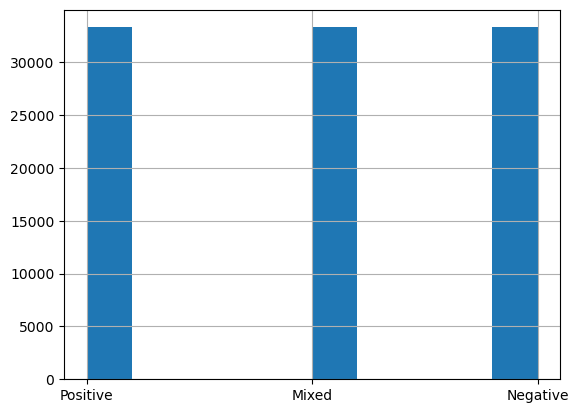

In [ ]:
# print num of saamples in each class to chech the unbalance
data['label'].value_counts()

# using histgram to chech the unbalance
data['label'].hist()

In [ ]:
# encode the label for each class
label_mapping = {"Positive": 0, "Mixed": 1, "Negative": 2}
data["label"] = [label_mapping[label] for label in data['label'].tolist()]
data

,label,text
0,0,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,0,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,0,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,0,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,0,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
...,...,...
99994,2,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
99995,2,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
99996,2,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
99997,2,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...


In [ ]:
# perform the preprocess_text function on the text
data['text'] = data['text'].apply(preprocess_text)
data

,label,text
0,0,ممتاز نوعا النظافة والموقع والتجهيز والشاطيء ا...
1,0,أسباب نجاح الإمارات شخص الدولة يعشق ترابها نحب...
2,0,هادفة وقوية تنقلك صخب شوارع القاهرة الى هدوء ج...
3,0,خلصنا مبدئيا اللي مستني ابهار زي الفيل الازرق ...
4,0,ياسات جلوريا جزء يتجزأ دبي فندق متكامل الخدمات...
...,...,...
99994,2,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني البد...
99995,2,يستحق ان يكون بوكنق لانه سيئ شي يوجد خدمة افطا...
99996,2,كتاب ضعيف جدا ولم استمتع فى قصه سرد لحاله مشهد...
99997,2,مملة جدا محمد حسن علوان فنان والوصف عندة دقيق ...


In [ ]:
# shuffle the data records
data = data.sample(frac=1.0, random_state=42).reset_index(drop=True)
data

,label,text
0,0,أقم الماشي بصورة الغرفة جيدة وكل شيء متوفر عدم...
1,2,تعجبني كباقي السلسلة متحمس لقراءة الجزء الثاني
2,0,المكان ممتاز والأمن والاستقبال اوكي التكييف وب...
3,2,القصة اجمالا مشوقة كونها تعتمد علي شخصيات يجمع...
4,1,اربع نجوم الملل اصابني النهاية رواية جميلة بال...
...,...,...
99994,0,تجربه جميله الطعام ممتاز الغداء والافطار وصولي...
99995,1,امتعتنى الرواية وآلمتنى جدااا بالسوء الذى يصور...
99996,2,حسنا رغم شدة اعجابي باليابانيين وثقافتهم وطريق...
99997,0,أنصح بالأقامة الفندق السيء موقع الفندق ممتاز ت...


In [ ]:
# check the duplicates
duplicates = data.duplicated().sum()
duplicates

109

In [ ]:
# drop the duplicates
data = data.drop_duplicates(keep='first')
duplicates = data.duplicated().sum()
duplicates

0

In [ ]:
# divide the whole data into train and val
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
train_data
val_data

,label,text
35222,2,شوية شخبطه مالوش الكتابة مشهور والناس بياكلها ...
39781,2,الصعب تخلق فيلما جيدا بطل خارق الفضاء تحدث الم...
59696,1,نعرف شيء الدنيا مانعيشه سنوات زمن آخر نكون عمر...
97339,1,شعرت الصفحة الاولى وكان المكتوب مقتبس احدى روا...
88569,1,حكيم العجم دمشق الرجل الناصرى تحدث رب الجلال ا...
...,...,...
6266,2,الخدمه بطئيه التاخر طلب وجبة الفطور جدا سئي ول...
54935,1,صالح للسكن العائلات الفندق لائق لسكن العائلات ...
76891,2,نجمتان ونصف فارق كبير الفضول والاهتمام قارن ال...
860,2,باختصار شديد قصة عادية جدا تكررت روايتها ألسنة...


,label,text
51925,0,مجموعة قصصية مميزة لنجيب محفوظ
63992,0,مرة أقرأ كتب النوعية دي ولأحمد ديدات الكتاب فع...
97278,2,انتهيت قراءته غضون ساعات محاولة جيدة كاتب عربي...
19925,0,فندق جيد جدا الفطور متنوع يوم الفطور تغير طبقي...
82793,2,سيء يوجد سيء جدا يوجد نت يوجد مواقف عدم وجود ث...
...,...,...
94135,2,اختزال لتاريخ الحضارات القديمه اول الفراعنه لل...
89844,1,مقبول ال يكن تجاوب الاستقبال خدمة الغرف عبر ال...
44651,0,اسلوب سلس وافكار مترابطه تشعر بالملل او الضياع...
99066,0,رائع الموقعالافطارطاقم الموظفين الاستقبال والا...


In [ ]:
# convert train_data and val_data from pandas dataframe to Hugging Face Dataset
train_data = Dataset.from_pandas(train_data)
val_data = Dataset.from_pandas(val_data)

In [ ]:
# Create an empty DatasetDict to store different splits of my dataset
datasets = DatasetDict()

# Add the training data to the DatasetDict under the key 'train'
datasets['train']   = train_data

# Add the validation data to the DatasetDict under the key 'val'
datasets['val']   = val_data
datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 79912
    })
    val: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 19978
    })
})

In [ ]:
train_data = datasets['train']
print(train_data.column_names)
print("="*50)
print(train_data[0])
print("="*50)
print(train_data.features)
print("="*50)
print(train_data[:3])

['label', 'text', '__index_level_0__']
{'label': 2, 'text': 'شوية شخبطه مالوش الكتابة مشهور والناس بياكلها الفضول ناحية المشاهير', '__index_level_0__': 35222}
{'label': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}
{'label': [2, 2, 1], 'text': ['شوية شخبطه مالوش الكتابة مشهور والناس بياكلها الفضول ناحية المشاهير', 'الصعب تخلق فيلما جيدا بطل خارق الفضاء تحدث المخرج كوينتن تارنتينو سوبر مان أبطاله الخارقين ولكنه رغم يعلم أنه الصعب جدا صنع فيلما جيدا عنه تبعا للقواعد ببساطة لأنه يوجد عنده نقطة تتعاطف معه قمت بصناعة فيلم سوبر مان سأهتم بمحاولته التعايش معنا بشخصية كلارك كنت وليس بمعاركه والأشرار الضئيلين أمامه كلمات تارنتينو تنطبق بشكل شبة حرفي البطل الخارق الآخر ثور وعن أزمة الجزء الثاني السلسلة تحمل اسمه جعلته فيلما محدودا جدا رغم لحظاته الجيدة الجزء أخرجه المخرج الكبير كينيث براناه عام استطاع تجاوز الخاصة بالعالم الحقيقي ينطلق وذلك خلال الحبكة الشكسبيرية لصانع أفلام دائما ارتبط اسمه شكسبير قدم براناه أفلام مسرح

# Load Model & Tokenizer
---------
----------
==> at this part I used (CAMeL-Lab/bert-base-arabic-camelbert-msa) model for finetuning you can find it on hugging face at: https://huggingface.co/CAMeL-Lab/bert-base-arabic-camelbert-msa



In [ ]:
# load model and tokenizer

model_ckpt = "CAMeL-Lab/bert-base-arabic-camelbert-msa"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = len(set(data['label']))
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Tokenizer
----------------------
--------------

In [ ]:
# tokenization function
def tokenize_batch(batch_text):
    return  tokenizer(batch_text['text'], padding='max_length', truncation=True, max_length=512)

In [ ]:
# perform the tokenization function on both training and val data
datasets_encoded = datasets.map(tokenize_batch, batched=True, batch_size=512)

Map:   0%|          | 0/79912 [00:00<?, ? examples/s]

Map:   0%|          | 0/19978 [00:00<?, ? examples/s]

In [ ]:
# print labels of the data after tokeniztion
print(datasets_encoded.column_names)

{'train': ['label', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'], 'val': ['label', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']}


In [ ]:
len(datasets_encoded['train']['input_ids'][1])

512

In [ ]:
# print some model specs
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30000
1000000000000000019884624838656
['input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
# convert the datasets_encoded to tnsors because of the compatibility of model
datasets_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label", "token_type_ids"])

# Trainer
------
--------
==> accuracy, f1, precision, and recall were used to evalute oure training process

In [ ]:
# define function to compute different metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")

    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

In [2]:
# empty the ram
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
batch_size = 8
logging_steps = len(datasets["train"]) // batch_size

model_name = f"{model_ckpt}-finetuned-Arabic_sentment_analysis_3"


# specify training arguments
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps ,
    log_level="error",
    save_total_limit=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=datasets_encoded["train"],
    eval_dataset=datasets_encoded["val"],
    tokenizer=tokenizer,

)

# Start
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.564800,0.627221,0.716538,0.713268,0.712738,0.716538
2,0.515900,0.706339,0.724847,0.724688,0.725451,0.724847
3,0.388700,0.899850,0.720242,0.720955,0.722200,0.720242


TrainOutput(global_step=29967, training_loss=0.48978628281474207, metrics={'train_runtime': 8155.5655, 'train_samples_per_second': 29.395, 'train_steps_per_second': 3.674, 'total_flos': 6.307775831243981e+16, 'train_loss': 0.48978628281474207, 'epoch': 3.0})

In [ ]:
# # resume training from the last check points
# trainer.train(resume_from_checkpoint = True)

# save the model
---------------------
---------------------

In [ ]:
# save the model and tokenizer
model.save_pretrained(model_name)
tokenizer.save_pretrained(model_name)

('CAMeL-Lab/bert-base-arabic-camelbert-msa-finetuned-Arabic_sentment_analysis_3/tokenizer_config.json',
 'CAMeL-Lab/bert-base-arabic-camelbert-msa-finetuned-Arabic_sentment_analysis_3/special_tokens_map.json',
 'CAMeL-Lab/bert-base-arabic-camelbert-msa-finetuned-Arabic_sentment_analysis_3/vocab.txt',
 'CAMeL-Lab/bert-base-arabic-camelbert-msa-finetuned-Arabic_sentment_analysis_3/added_tokens.json',
 'CAMeL-Lab/bert-base-arabic-camelbert-msa-finetuned-Arabic_sentment_analysis_3/tokenizer.json')

# inference

In [ ]:
# load our model to use it for inference and evalute its performance
model_ckpt = "CAMeL-Lab/bert-base-arabic-camelbert-msa-finetuned-Arabic_sentment_analysis_3/model_weights"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = len(set(data['label']))
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

In [ ]:
# define a function take the text and return the prediction
def get_pridiction(in_text):
    in_text_clean = pd.Series(in_text).apply(preprocess_text)
    batch = tokenizer(str(in_text_clean) ,  return_tensors="pt").to(device)

    # Forward pass to get logits
    with torch.no_grad():
        logits = model(**batch).logits

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    if torch.argmax(probabilities) == 0:
        return print('Positive')
    elif torch.argmax(probabilities) == 1:
        return print('Mixed')
    elif torch.argmax(probabilities) == 2:
        return print('Negative')

In [ ]:
in_text = "التعلم واكتساب المهارات يفتحان أفقًا جديدًا من الفرص"
results = get_pridiction(in_text)
results

Positive


In [ ]:
in_text = "فرحان اوى"
results = get_pridiction(in_text)
results

Mixed


In [ ]:
in_text = "لا يسعك سوى التهام دواوينه"
results = get_pridiction(in_text)
results

Negative


In [ ]:
.